In [1]:
# !pip3 install -U torch_geometric
# !pip3 install -U torch-scatter
# !pip3 install -U torch-sparse
# !pip3 install -U pandas
# !pip3 install -U numpy
# !pip3 install -U matplotlib
# !pip3 install -U sklearn
# !pip3 install -U PyTDC 
# !pip3 install -U pre-commit
# !pip3 install -U plotly
# !pip3 install -U tdc 
# !pip3 install -U ogb

In [2]:
# !pip install ogb==1.2.6

In [3]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdkit

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from tdc.single_pred import Tox
from rdkit.Chem import AllChem
from rdkit import Chem

from time import time

<IPython.core.display.Javascript object>

In [5]:
from featurizers.fingerprints import (
    MorganFingerprint,
    MACCSKeysFingerprint,
    AtomPairFingerprint,
    TopologicalTorsionFingerprint,
    ERGFingerprint,
)

from rdkit.Chem import MolFromSmiles

<IPython.core.display.Javascript object>

In [6]:
hiv_df = pd.read_csv("mol.csv.gz")

<IPython.core.display.Javascript object>

In [7]:
hiv_df.head(8)

,HIV_active,smiles,mol_id
0,0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,NaN
1,0,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,NaN
2,0,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,NaN
3,0,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,NaN
4,0,O=S(=O)(O)CCS(=O)(=O)O,NaN
5,0,CCOP(=O)(Nc1cccc(Cl)c1)OCC,NaN
6,0,O=C(O)c1ccccc1O,NaN
7,0,CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O,NaN


<IPython.core.display.Javascript object>

In [8]:
X = hiv_df["smiles"]

<IPython.core.display.Javascript object>

In [9]:
n_molecules = X.shape[0]
n_molecules

41127

<IPython.core.display.Javascript object>

In [10]:
def get_times_emf(X, n_molecules, transformer_function, **kwargs):
    result = []
    emf_transformer = transformer_function(**kwargs)
    for part in range(2, 11, 2):
        n = (n_molecules * part) // 10
        subset = X[:n]
        times = [None for i in range(5)]
        for i in range(5):
            start = time()
            X_transformed = emf_transformer.transform(subset)
            end = time()

            times[i] = end - start
        result.append(sum(times) / 5)
    return np.array(result)

<IPython.core.display.Javascript object>

In [11]:
def get_times_rdkit(X, n_molecules, func, **kwargs):
    result = []
    for part in range(2, 11, 2):
        n = (n_molecules * part) // 10
        subset = X[:n]
        times = [None for i in range(5)]
        for i in range(5):
            start = time()
            X_transformed = [func(MolFromSmiles(x), **kwargs) for x in subset]
            end = time()

            times[i] = end - start
        result.append(sum(times) / 5)
    return np.array(result)

<IPython.core.display.Javascript object>

In [31]:
def plot_results(y_emf, y_rdkit, title="", upper_bound=1):
    X = np.arange(2, 11, 2)

    y_emf = y_emf * 1000 / (n_molecules * X / 10)
    y_rdkit = y_rdkit * 1000 / (n_molecules * X / 10)

    plt.rcParams["font.size"] = 20
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot()
    ax1.set_title(title)

    ax1.plot(X * 10, y_emf, label="emf time")
    ax1.plot(X * 10, y_rdkit, label="rdkit time")

    ax1.set_ylabel("Average time for one fingerprint [ms]")
    ax1.set_xlabel("part of the input set [%]")

    ax1.set_xlim(18, 102)
    ax1.set_ylim(-0.05, upper_bound)

    plt.legend(loc="upper left")
    plt.show()

<IPython.core.display.Javascript object>

## Morgan Fingerprint

In [13]:
fingerprint_types = ["default", "as_bit_vect", "hashed"]
morgan_emf_times = [
    get_times_emf(
        X, n_molecules, MorganFingerprint, result_type=tp, radius=3, n_jobs=-1
    )
    for tp in fingerprint_types
]

<IPython.core.display.Javascript object>

In [14]:
from rdkit.Chem.rdMolDescriptors import (
    GetMorganFingerprint,
    GetMorganFingerprintAsBitVect,
    GetHashedMorganFingerprint,
)

functions = [
    GetMorganFingerprint,
    GetMorganFingerprintAsBitVect,
    GetHashedMorganFingerprint,
]
morgan_rdkit_times = [
    get_times_rdkit(X, n_molecules, function, radius=3) for function in functions
]

[13:15:13] WARNING: not removing hydrogen atom without neighbors
[13:15:13] WARNING: not removing hydrogen atom without neighbors
[13:15:30] WARNING: not removing hydrogen atom without neighbors
[13:15:30] WARNING: not removing hydrogen atom without neighbors
[13:15:47] WARNING: not removing hydrogen atom without neighbors
[13:15:47] WARNING: not removing hydrogen atom without neighbors
[13:16:02] WARNING: not removing hydrogen atom without neighbors
[13:16:02] WARNING: not removing hydrogen atom without neighbors
[13:16:18] WARNING: not removing hydrogen atom without neighbors
[13:16:18] WARNING: not removing hydrogen atom without neighbors
[13:18:57] WARNING: not removing hydrogen atom without neighbors
[13:18:57] WARNING: not removing hydrogen atom without neighbors
[13:19:12] WARNING: not removing hydrogen atom without neighbors
[13:19:12] WARNING: not removing hydrogen atom without neighbors
[13:19:26] WARNING: not removing hydrogen atom without neighbors
[13:19:26] WARNING: not r

<IPython.core.display.Javascript object>

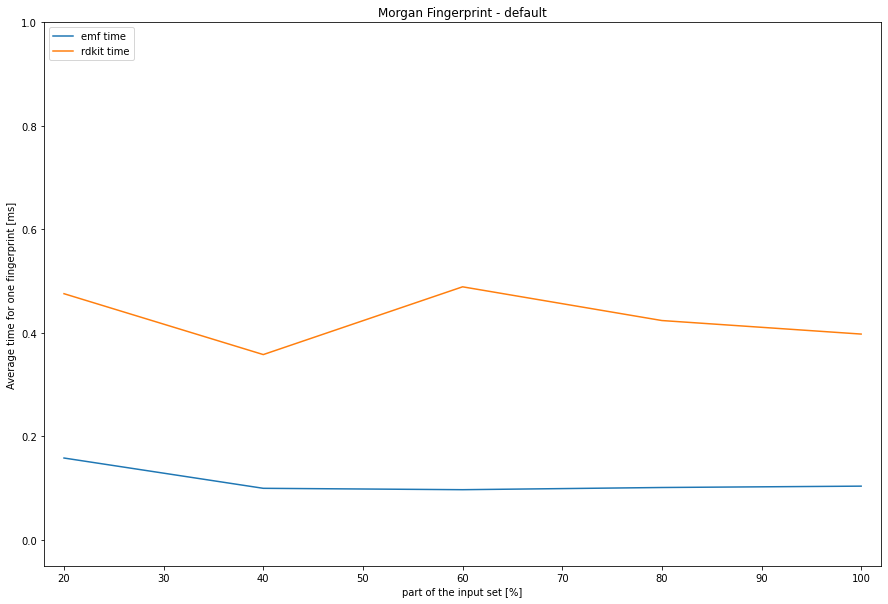

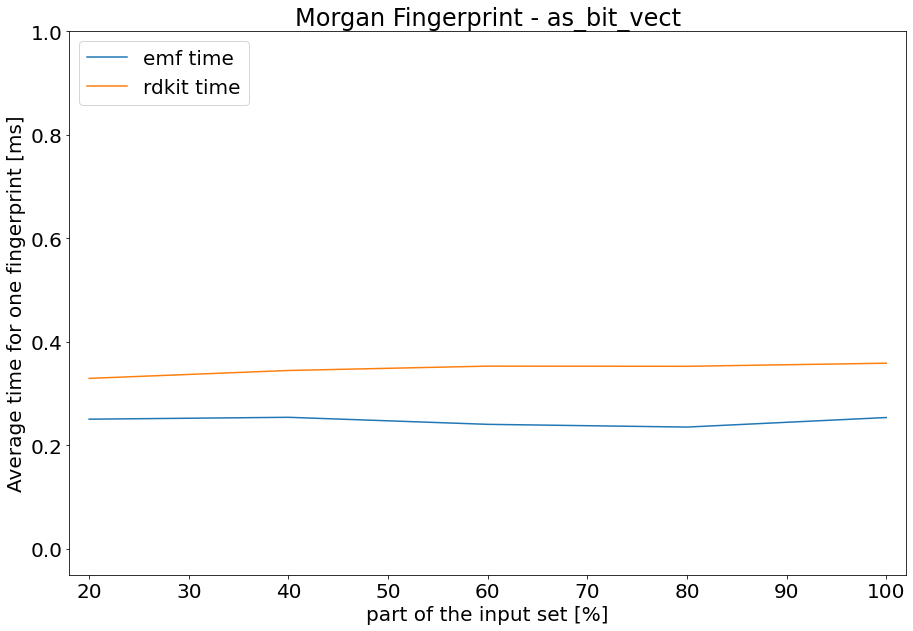

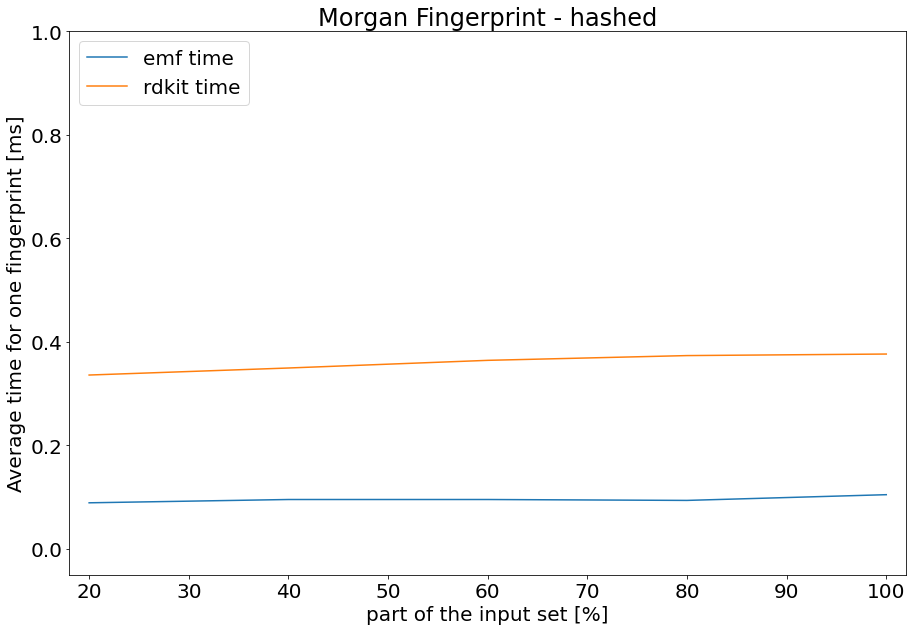

<IPython.core.display.Javascript object>

In [15]:
for i in range(3):
    plot_results(
        morgan_emf_times[i],
        morgan_rdkit_times[i],
        "Morgan Fingerprint - " + fingerprint_types[i],
    )

## MACCS Keys

In [16]:
MACCSKeys_emf_times = get_times_emf(X, n_molecules, MACCSKeysFingerprint, n_jobs=-1)

<IPython.core.display.Javascript object>

In [17]:
from rdkit.Chem.rdMolDescriptors import GetMACCSKeysFingerprint

MACCSKeys_rdkit_times = get_times_rdkit(X, n_molecules, GetMACCSKeysFingerprint)

[13:42:18] WARNING: not removing hydrogen atom without neighbors
[13:42:18] WARNING: not removing hydrogen atom without neighbors
[13:43:36] WARNING: not removing hydrogen atom without neighbors
[13:43:36] WARNING: not removing hydrogen atom without neighbors
[13:44:54] WARNING: not removing hydrogen atom without neighbors
[13:44:54] WARNING: not removing hydrogen atom without neighbors
[13:46:14] WARNING: not removing hydrogen atom without neighbors
[13:46:14] WARNING: not removing hydrogen atom without neighbors
[13:47:32] WARNING: not removing hydrogen atom without neighbors
[13:47:32] WARNING: not removing hydrogen atom without neighbors


<IPython.core.display.Javascript object>

In [ ]:
print(MACCSKeys_emf_times, MACCSKeys_rdkit_times)

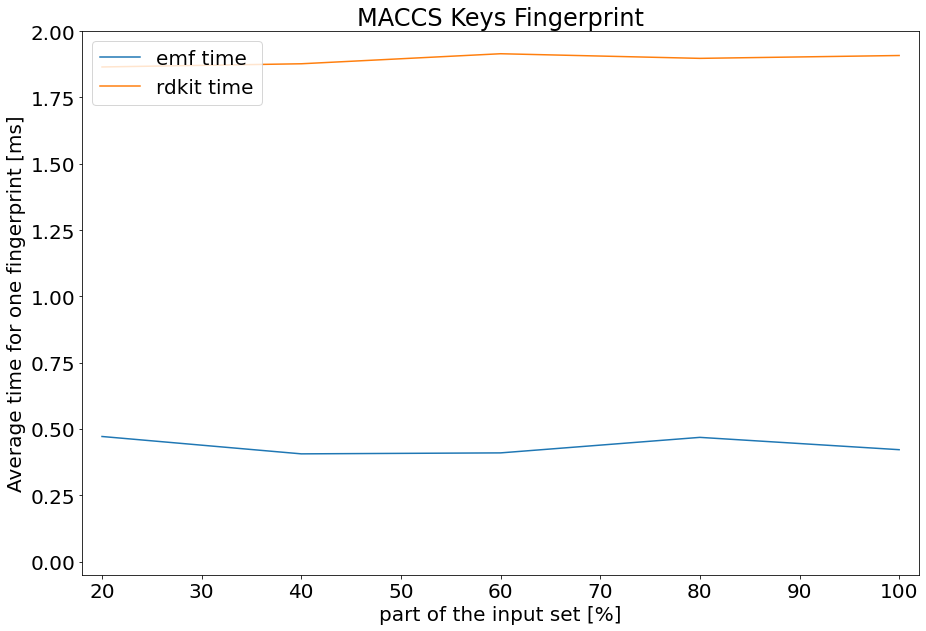

<IPython.core.display.Javascript object>

In [32]:
plot_results(MACCSKeys_emf_times, MACCSKeys_rdkit_times, "MACCS Keys Fingerprint", 2)

## Atom Pair

In [19]:
fingerprint_types = ["default", "as_bit_vect", "hashed"]
atom_pair_emf_times = [
    get_times_emf(X, n_molecules, AtomPairFingerprint, result_type=tp, n_jobs=-1)
    for tp in fingerprint_types
]

<IPython.core.display.Javascript object>

In [20]:
from rdkit.Chem.rdMolDescriptors import (
    GetAtomPairFingerprint,
    GetHashedAtomPairFingerprintAsBitVect,
    GetHashedAtomPairFingerprint,
)

functions = [
    GetAtomPairFingerprint,
    GetHashedAtomPairFingerprintAsBitVect,
    GetHashedAtomPairFingerprint,
]
arom_pair_rdkit_times = [
    get_times_rdkit(X, n_molecules, function) for function in functions
]

[13:55:24] WARNING: not removing hydrogen atom without neighbors
[13:55:24] WARNING: not removing hydrogen atom without neighbors
[13:55:40] WARNING: not removing hydrogen atom without neighbors
[13:55:40] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:55:55] WARNING: not removing hydrogen atom without neighbors
[13:56:09] WARNING: not removing hydrogen atom without neighbors
[13:56:09] WARNING: not removing hydrogen atom without neighbors
[13:56:24] WARNING: not removing hydrogen atom without neighbors
[13:56:24] WARNING: not removing hydrogen atom without neighbors
[13:59:02] WARNING: not removing hydrogen atom without neighbors
[13:59:02] WARNING: not removing hydrogen atom without neighbors
[13:59:16] WARNING: not removing hydrogen atom without neighbors
[13:59:16] WARNING: not removing hydrogen atom without neighbors
[13:59:31] WARNING: not removing hydrogen atom without neighbors
[13:59:31] WARNING: not r

<IPython.core.display.Javascript object>

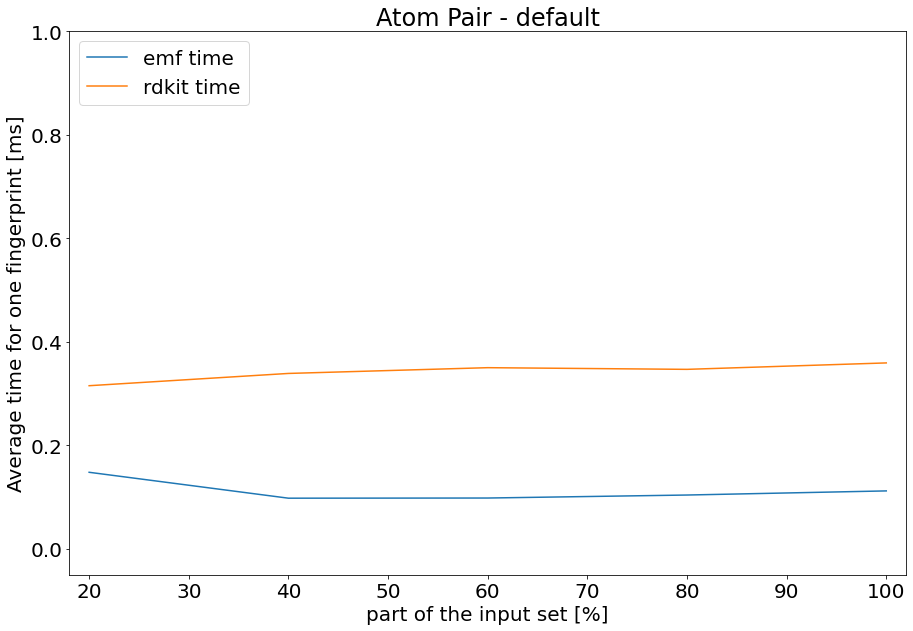

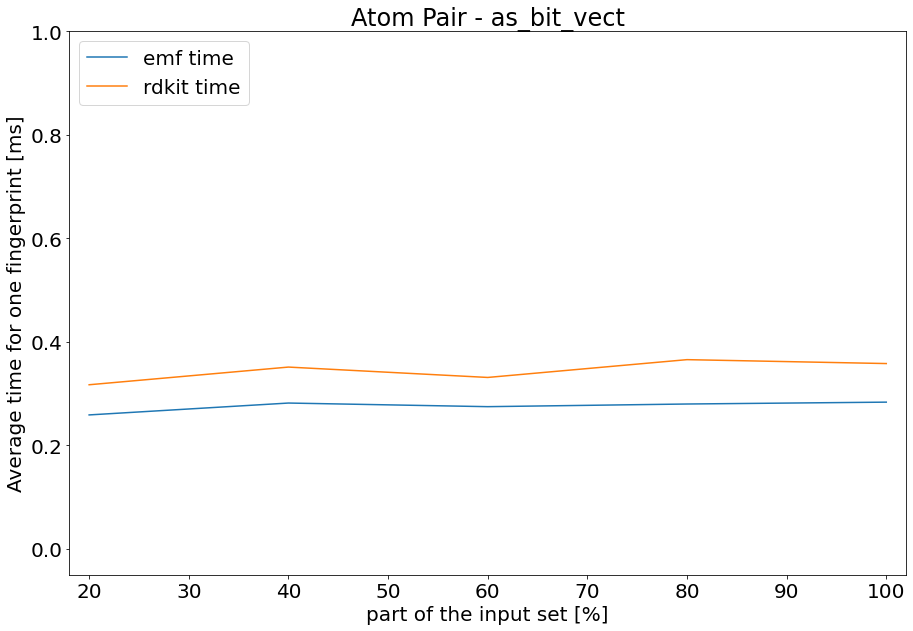

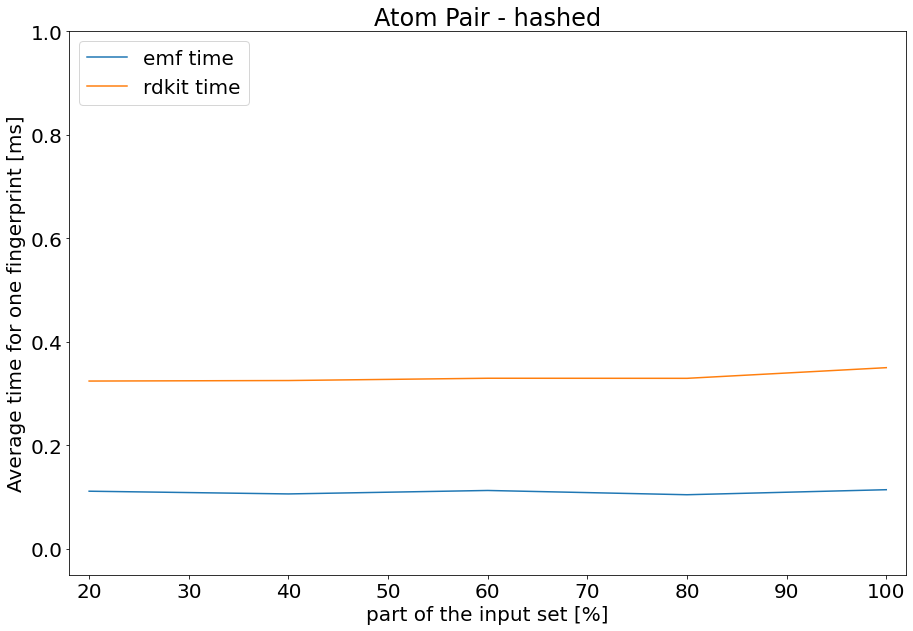

<IPython.core.display.Javascript object>

In [23]:
for i in range(3):
    plot_results(
        atom_pair_emf_times[i],
        arom_pair_rdkit_times[i],
        "Atom Pair - " + fingerprint_types[i],
    )

## Topological Torsion

In [24]:
fingerprint_types = ["default", "as_bit_vect", "hashed"]
topological_torsion_emf_times = [
    get_times_emf(
        X, n_molecules, TopologicalTorsionFingerprint, result_type=tp, n_jobs=-1
    )
    for tp in fingerprint_types
]

<IPython.core.display.Javascript object>

In [26]:
from rdkit.Chem.rdMolDescriptors import (
    GetTopologicalTorsionFingerprint,
    GetHashedTopologicalTorsionFingerprintAsBitVect,
    GetHashedTopologicalTorsionFingerprint,
)

functions = [
    GetTopologicalTorsionFingerprint,
    GetHashedTopologicalTorsionFingerprintAsBitVect,
    GetHashedTopologicalTorsionFingerprint,
]
topological_torsion_rdkit_times = [
    get_times_rdkit(X, n_molecules, function) for function in functions
]

[14:45:27] WARNING: not removing hydrogen atom without neighbors
[14:45:27] WARNING: not removing hydrogen atom without neighbors
[14:45:45] WARNING: not removing hydrogen atom without neighbors
[14:45:45] WARNING: not removing hydrogen atom without neighbors
[14:46:03] WARNING: not removing hydrogen atom without neighbors
[14:46:03] WARNING: not removing hydrogen atom without neighbors
[14:46:21] WARNING: not removing hydrogen atom without neighbors
[14:46:21] WARNING: not removing hydrogen atom without neighbors
[14:46:38] WARNING: not removing hydrogen atom without neighbors
[14:46:38] WARNING: not removing hydrogen atom without neighbors
[14:49:42] WARNING: not removing hydrogen atom without neighbors
[14:49:42] WARNING: not removing hydrogen atom without neighbors
[14:49:59] WARNING: not removing hydrogen atom without neighbors
[14:49:59] WARNING: not removing hydrogen atom without neighbors
[14:50:15] WARNING: not removing hydrogen atom without neighbors
[14:50:15] WARNING: not r

<IPython.core.display.Javascript object>

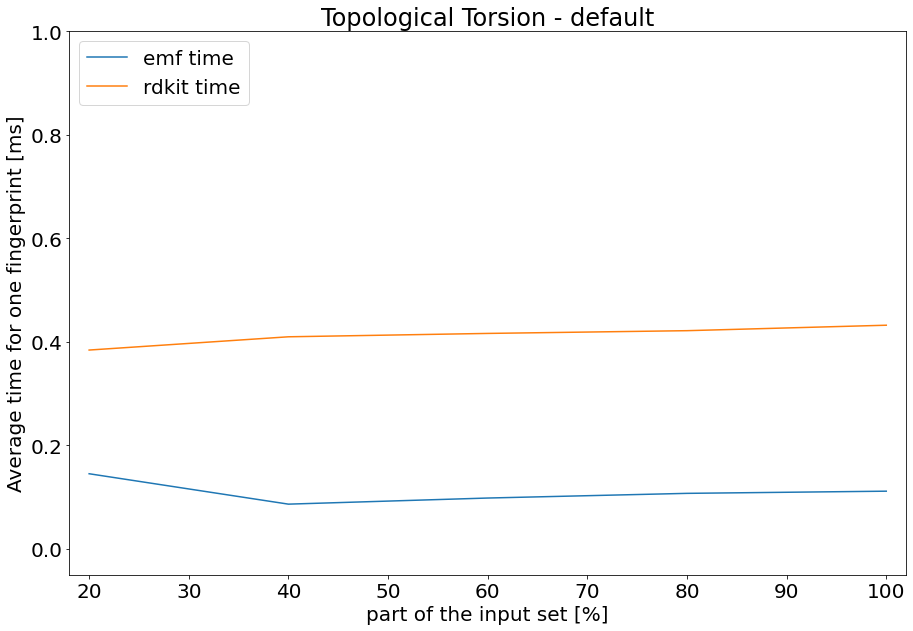

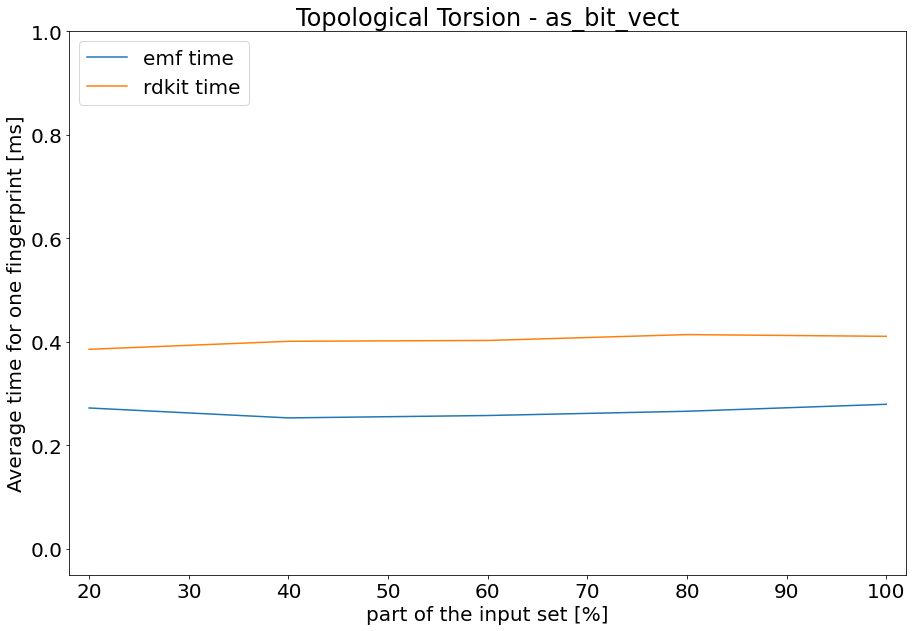

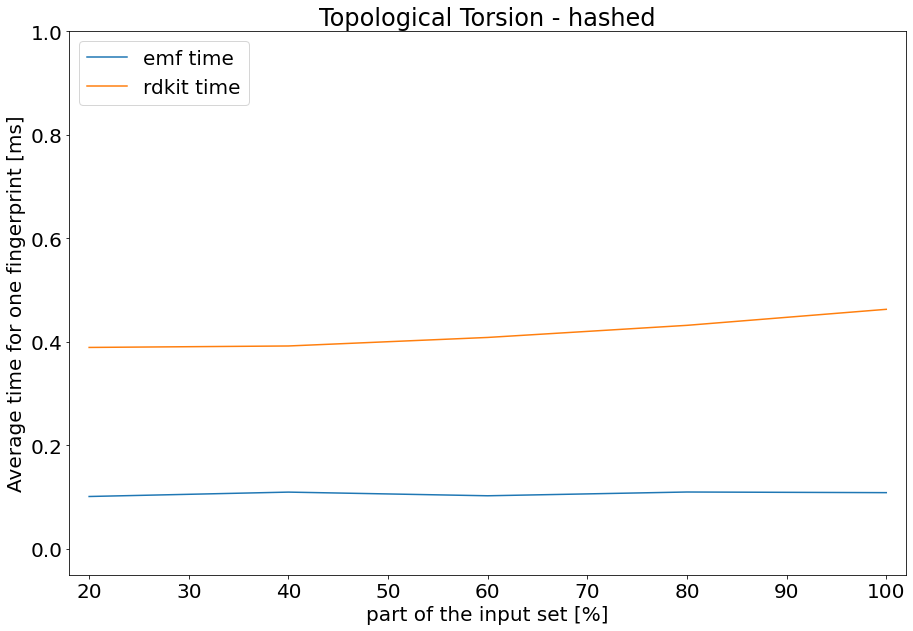

<IPython.core.display.Javascript object>

In [27]:
for i in range(3):
    plot_results(
        topological_torsion_emf_times[i],
        topological_torsion_rdkit_times[i],
        "Topological Torsion - " + fingerprint_types[i],
    )

## ERG Fingerprint

In [28]:
ERG_emf_times = get_times_emf(X, n_molecules, ERGFingerprint, n_jobs=-1)

<IPython.core.display.Javascript object>

In [29]:
from rdkit.Chem.rdReducedGraphs import GetErGFingerprint

ERG_rdkit_times = get_times_rdkit(X, n_molecules, GetErGFingerprint)

[15:01:32] WARNING: not removing hydrogen atom without neighbors
[15:01:32] WARNING: not removing hydrogen atom without neighbors
[15:01:56] WARNING: not removing hydrogen atom without neighbors
[15:01:56] WARNING: not removing hydrogen atom without neighbors
[15:02:20] WARNING: not removing hydrogen atom without neighbors
[15:02:20] WARNING: not removing hydrogen atom without neighbors
[15:02:45] WARNING: not removing hydrogen atom without neighbors
[15:02:45] WARNING: not removing hydrogen atom without neighbors
[15:03:10] WARNING: not removing hydrogen atom without neighbors
[15:03:10] WARNING: not removing hydrogen atom without neighbors


<IPython.core.display.Javascript object>

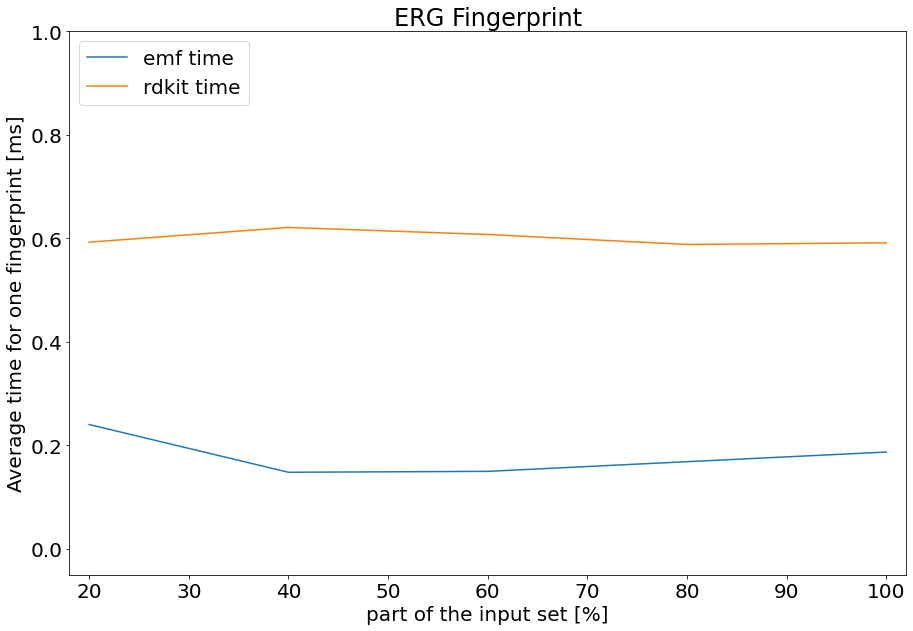

<IPython.core.display.Javascript object>

In [30]:
plot_results(ERG_emf_times, ERG_rdkit_times, "ERG Fingerprint")